# 2.Combined visualization of domains and segmented cells

This notebook shows how to identify spatial domains based on SCC clustering result, and 
how to combine domains and segmented cells for informative visualization.

The anndata of segmented cells can be obtained from the cell segmentation module of spateo. 
As we use single-cell processing pipeline to cluster and annotate segmented cells (cellbins), 
we skip the clustering for cellbins. Please see the spateo.sc module tutorial for more information.

## Packages

In [1]:
import spateo as st

2022-11-10 20:41:12.518556: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
network.py (36): The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.


|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


## Data source
**bin60_clustered_h5ad:** https://www.dropbox.com/s/wxgkim87uhpaz1c/mousebrain_bin60_clustered.h5ad?dl=0

**cellbin_clustered_h5ad:** https://www.dropbox.com/s/seusnva0dgg5de5/mousebrain_cellbin_clustered.h5ad?dl=0


In [2]:
# Load annotated binning data
fname_bin60 = "mousebrain_bin60_clustered.h5ad"
adata_bin60 = st.sample_data.mousebrain(fname_bin60)

# Load annotated cellbin data
fname_cellbin = "mousebrain_cellbin_clustered.h5ad"
adata_cellbin = st.sample_data.mousebrain(fname_cellbin)

adata_bin60, adata_cellbin

(AnnData object with n_obs × n_vars = 7765 × 21667
     obs: 'area', 'n_counts', 'Size_Factor', 'initial_cell_size', 'louvain', 'scc', 'scc_anno'
     var: 'pass_basic_filter'
     uns: '__type', 'louvain', 'louvain_colors', 'neighbors', 'pp', 'scc', 'scc_anno_colors', 'scc_colors', 'spatial', 'spatial_neighbors'
     obsm: 'X_pca', 'X_spatial', 'bbox', 'contour', 'spatial'
     layers: 'count', 'spliced', 'unspliced'
     obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances',
 AnnData object with n_obs × n_vars = 11854 × 14645
     obs: 'area', 'pass_basic_filter', 'n_counts', 'louvain', 'Celltype'
     var: 'mt', 'pass_basic_filter'
     uns: 'Celltype_colors', '__type', 'louvain', 'neighbors', 'spatial'
     obsm: 'X_pca', 'X_spatial', 'bbox', 'contour', 'spatial'
     layers: 'count', 'spliced', 'unspliced'
     obsp: 'connectivities', 'distances')

**bin30_h5ad:** https://www.dropbox.com/s/tyvhndoyj8se5xt/mousebrain_bin30.h5ad?dl=0

In [3]:
# Load higher resolution binning data (optional)
fname_bin30 = "mousebrain_bin30.h5ad"
adata_bin30 = st.sample_data.mousebrain(fname_bin30)

adata_bin30

AnnData object with n_obs × n_vars = 31040 × 25691
    obs: 'area'
    uns: '__type', 'spatial'
    obsm: 'X_spatial', 'bbox', 'contour', 'spatial'
    layers: 'count', 'spliced', 'unspliced'

## Identify spatial domains from SCC annotation

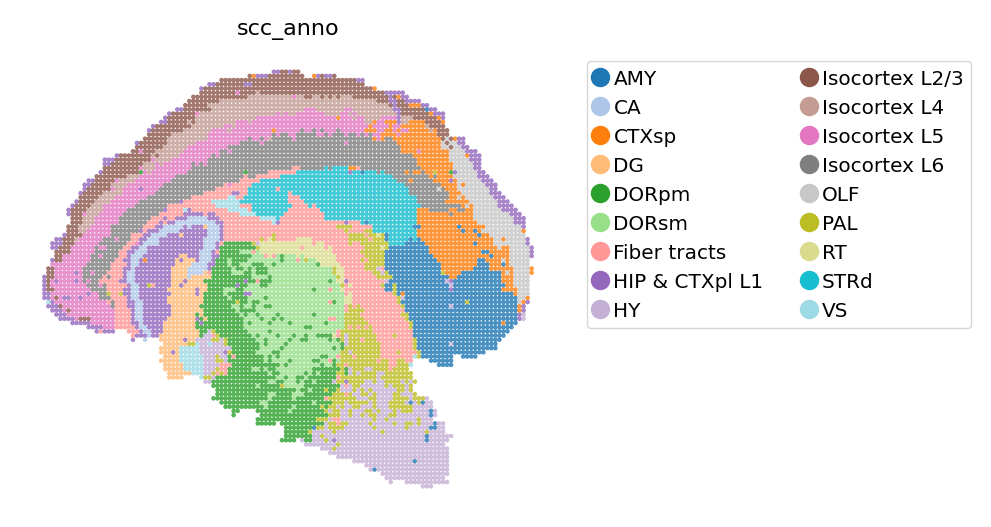

In [4]:
# SCC annotation
st.pl.space(
    adata_bin60,
    color=['scc_anno'],
    show_legend="upper left",
    figsize=(4, 3),
    color_key_cmap="tab20"
)

Spateo exploit the consistency of spatial coordinates, enabling domains to be identified and annotations to 
be transfered among binning data of different binsize and even cellbin data. This feature could be handy when 
the best binsize for clustering and for other analysis is different.

In [ ]:
# Extract spatial domains from SCC clusters.
# Transfer domain annotation to higher resolution anndata object for better visualization (optional).
st.dd.set_domains(
    adata_high_res=adata_bin30,
    adata_low_res=adata_bin60,
    bin_size_high=30,
    bin_size_low=60,
    cluster_key="scc_anno",
    k_size=1.8,
    min_area=16,
)

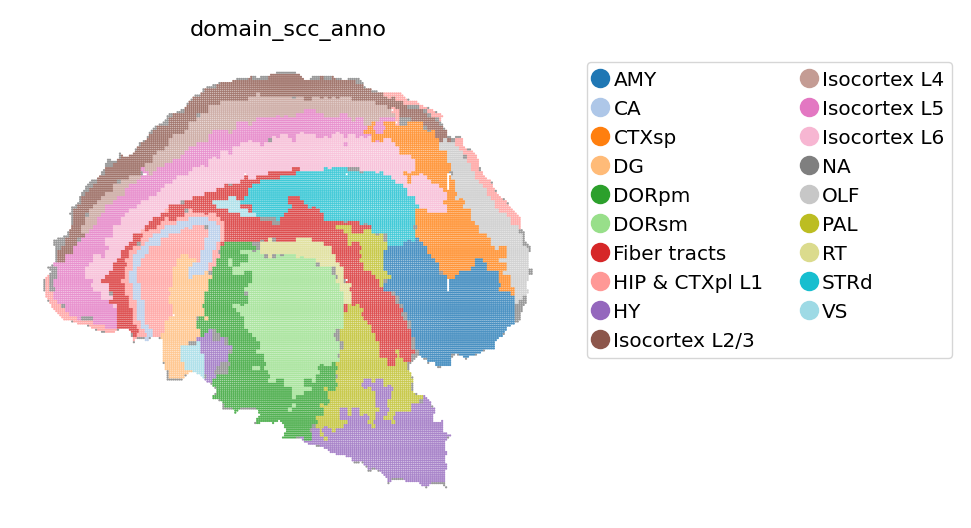

In [6]:
# View transfered spatial domain
st.pl.space(
    adata_bin30,
    color=['domain_scc_anno'],
    show_legend="upper left",
    figsize=(4, 3),
    color_key_cmap="tab20",
)

We extract the contours from identified domains, generating a contour image to represent 
spatial domains. We then use this image as a aligned background image and plot it along 
with segmented cells, giving a straight forward information on the spatial distribution 
of cells.

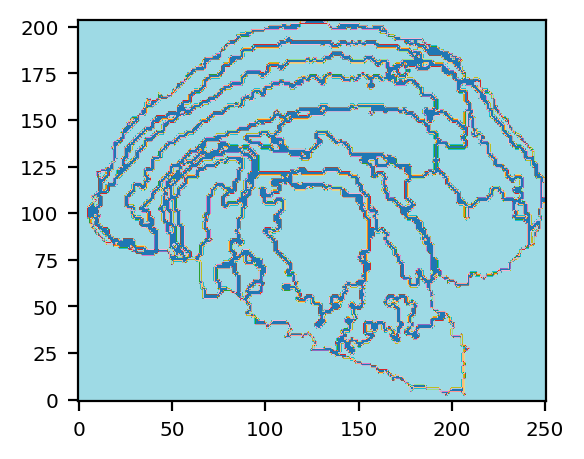

In [7]:
# Spatial domain contours
save_img_path = "spatial_domains.png"
st.pl.spatial_domains(adata_bin30, bin_size=30, label_key="domain_scc_anno", save_img=save_img_path)

## Visualization of cellbin data

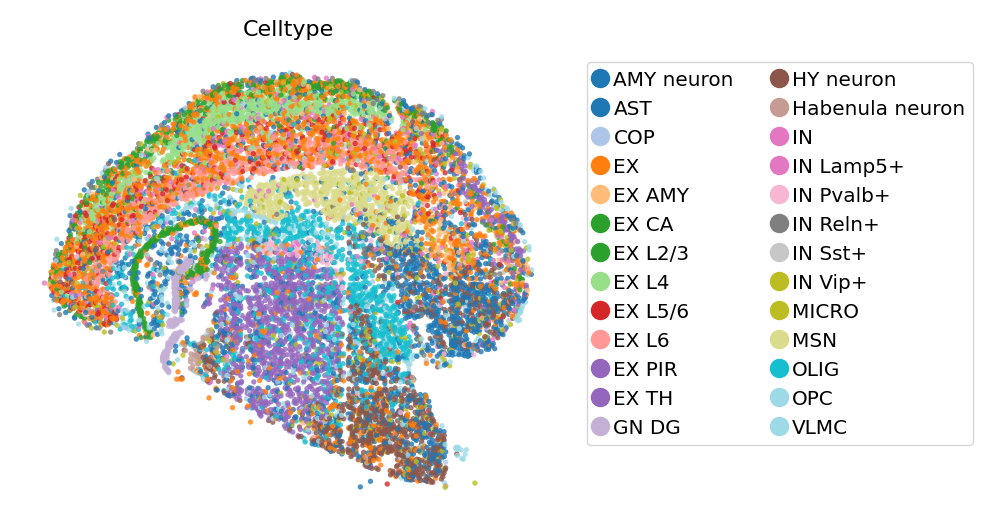

In [8]:
# View cells as points
st.pl.space(
    adata_cellbin,
    color=['Celltype'],
    pointsize=0.1,
    show_legend="upper left",
    figsize=(4, 3),
    color_key_cmap = "tab20",
)

Spateo implements a geometric plotting for segmented cells. Each cell is plotted as a 
ploygon, which is the convex hull of all the spots in the cell.

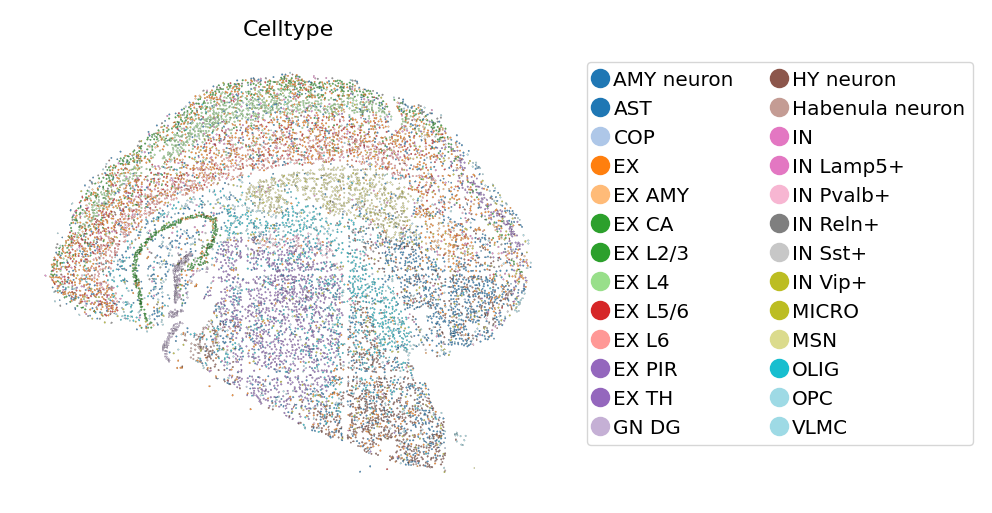

In [9]:
# View cells as geometrics
st.pl.geo(
    adata_cellbin,
    color=['Celltype'],
    boundary_width=0.05,
    show_legend="upper left",
    figsize=(4, 3),
    color_key_cmap = "tab20",
)

## Combined visualization of both domains and cells

By rescaling the spatial coordinates of cells to align with identifid spatial domains, 
we can plot cells above the pre-generated domain image.

In [10]:
# Rescale spatial coordinates
adata_cellbin.obsm['spatial_bin30'] = adata_cellbin.obsm['spatial']//30

# Load spatial domain image as background
adata_cellbin = st.io.read_image(
    adata_cellbin,
    filename=save_img_path,
    img_layer="layer1",
    slice="slice1",
    scale_factor=1,
)

# Save adata_cellbin with background domain image (Optional)
# adata_cellbin.write("mousebrain_cellbin_domain.h5ad", compression="gzip")

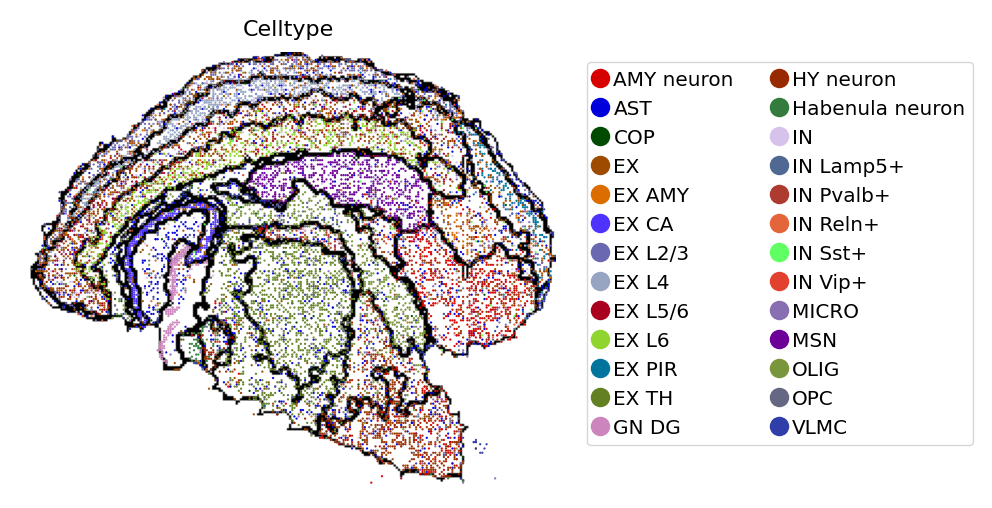

In [11]:
# View cells with domains as background
st.pl.space(
    adata_cellbin,
    space="spatial_bin30",
    color=['Celltype'],
    alpha=0.95,
    figsize=(4, 3),
    show_legend="upper left",
    img_layers = "layer1",
    slices="slice1",
)

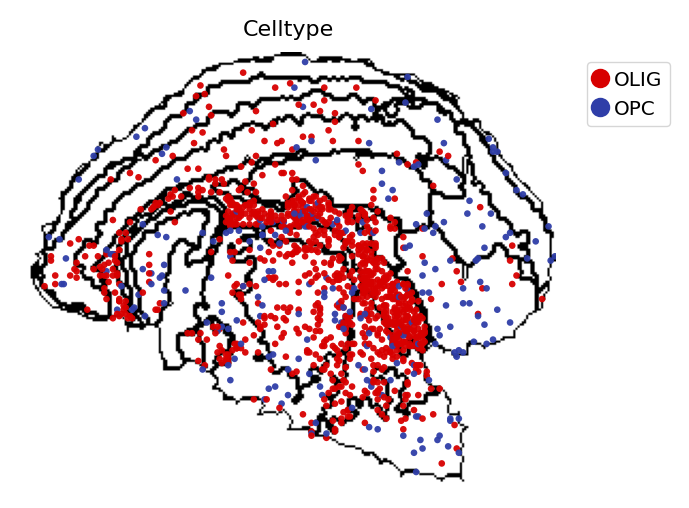

In [12]:
st.pl.space(
    adata_cellbin[adata_cellbin.obs['Celltype'].isin(["OLIG", "OPC"]), :],
    space="spatial_bin30",
    color=['Celltype'],
    alpha=0.95,
    pointsize=0.05,
    figsize=(4, 3),
    show_legend="upper left",
    img_layers = "layer1",
    slices="slice1",
)

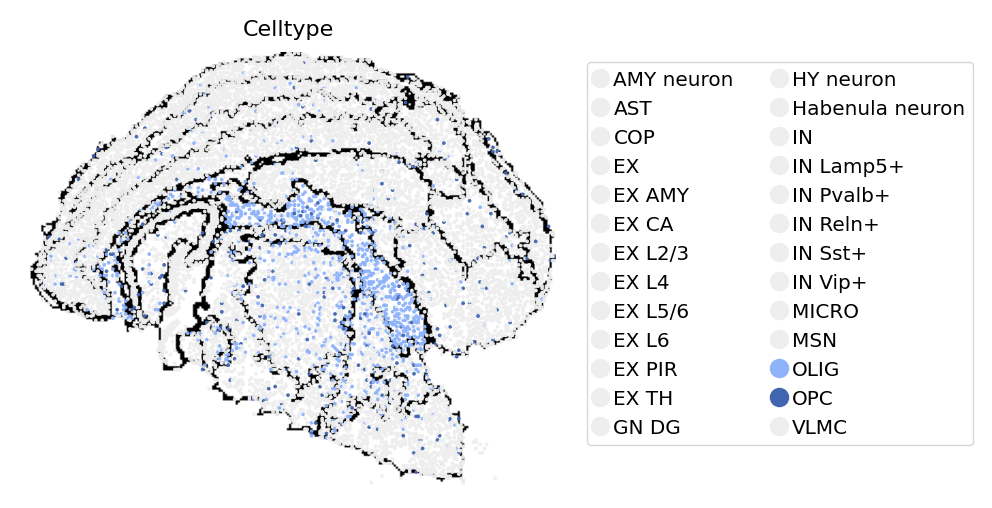

In [13]:
import numpy as np
color_palette = np.repeat(["#EEEEEEFF"],23).tolist() + ["#8eb3fbff","#4166afff"] + np.repeat(["#EEEEEEFF"],1).tolist()

st.pl.space(
    adata_cellbin,
    space="spatial_bin30",
    color=['Celltype'],
    color_key=color_palette,
    alpha=0.95,
    pointsize=0.05,
    figsize=(4, 3),
    show_legend="upper left",
    img_layers = "layer1",
    slices="slice1",
)